<a href="https://colab.research.google.com/github/niss10/IS-698-FL-Project/blob/main/FedCollab_FL_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimental file for testing and calculating precision/recall in FL.

# Prerequisite - Environment Setup
1. Run the below cell
2. Then, RESTART the Colab runtime. (after succefull completion)
3. After Restarting don't run this cell

In [ ]:

# Force‑reinstall NumPy and scikit‑learn
!pip install --upgrade --force-reinstall numpy==1.24.3 scikit-learn

# Install the CPU‑only PyTorch build
!pip uninstall -y torch torchvision
!pip install --index-url https://download.pytorch.org/whl/cpu torch torchvision

# Install/latest versions of Flower and PyTorch
!pip install --upgrade flwr pandas
!pip install -U "flwr[simulation]"

# Then, RESTART the Colab runtime.

# After Restarting don't run this cell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 756.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfu

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 97.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0+cpu which is incompatible.
torchaudio 2.6.0+cu124

## Import required libraries

In [ ]:
# Import required libraries
import flwr as fl
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from flwr.server.strategy import FedAvg
from flwr.client import NumPyClient
import matplotlib.pyplot as plt
import os
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Adding Master file
Setting source of truth file that we will use for federated learning simulation

upload the downloaded preprocessed_dataset.csv from Dataset/Pre-Processed/ folder

In [ ]:

# Adding Master dataset file
print("Please upload preprocessed_dataset.csv")
uploaded = files.upload()  # upload the downloaded preprocessed_dataset.csv
if(uploaded):
  print("File uploaded successfully")
else:
  print("File upload failed, Please upload again")
  uploaded = files.upload()

Please upload preprocessed_dataset.csv


Saving preprocessed_dataset.csv to preprocessed_dataset.csv
File uploaded successfully


# Data Partitioning for Client simulations

In [ ]:
# Data Partitioning Utility

# Load the master preprocessed dataset.
def load_master(csv_path):
    return pd.read_csv(csv_path)

# Randomly select N different user from all
def sample_user_ids(df, num_clients, seed=42):
    user_ids = df["UserID"].unique()
    rng = np.random.default_rng(seed)
    if num_clients >= len(user_ids):
        return list(user_ids)
    return list(rng.choice(user_ids, size=num_clients, replace=False))

# Save each selected user's rating to out_dir/user_{uid}.csv
def partition_by_user(df, out_dir, user_ids=None):
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    if user_ids is None:
        user_ids = df["UserID"].unique()

    csv_paths = []
    for uid in user_ids:
        df_user = df[df["UserID"] == uid]
        path = out_path / f"user_{uid}.csv"
        df_user.to_csv(path, index=False)
        csv_paths.append(str(path))
    return csv_paths

## Sanity check data of partioning

In [ ]:

# Load the master dataset that we have uploaded earlier
MASTER_CSV = "preprocessed_dataset.csv"
df_master  = load_master(MASTER_CSV)
print("Rows:", len(df_master), " | Users:", df_master['UserID'].nunique(), " | Movie:", df_master['MovieID'].nunique())

# Cheking for 5 clients
paths_5   = partition_by_user(df_master, "clients_5",   sample_user_ids(df_master, 5))


print(f"5-client num files:   {len(paths_5)}")
print(f"5-client files:   {paths_5}")


<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)


Rows: 1000209  | Users: 6040  | Movie: 3706
5-client num files:   5
5-client files:   ['clients_5/user_4673.csv', 'clients_5/user_2651.csv', 'clients_5/user_3953.csv', 'clients_5/user_539.csv', 'clients_5/user_2616.csv']


# Model & Local-Training Utilities
In this section we are difining model and how model will train data we have used REcommenderMLP using Pytorch for training.

## Loading Local data and Train/Test Split

In [ ]:
# Return train & test DataLoaders for one client CSV.
def load_client_data(csv_path, batch_size=32, test_size=0.2, seed=42):
    df = pd.read_csv(csv_path)
    users  = torch.tensor(df["UserID"].values,   dtype=torch.long)
    movies = torch.tensor(df["MovieID"].values,  dtype=torch.long)
    ratings= torch.tensor(df["Rating"].values,   dtype=torch.float32)

    idx = np.arange(len(df))
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    split = int((1 - test_size) * len(idx))
    train_idx, test_idx = idx[:split], idx[split:]

    train_ds = TensorDataset(users[train_idx], movies[train_idx], ratings[train_idx])
    test_ds  = TensorDataset(users[test_idx],  movies[test_idx],  ratings[test_idx])

    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(test_ds,  batch_size=batch_size, shuffle=False))

## Model

In [ ]:
# Defining RecommenderMLP Model using Pytorch

# User-embedding + Movie-embedding -> 2-layer MLP[64 -> ReLu] -> rating (1-5).
class RecommenderMLP(nn.Module):
    def __init__(self, num_users, num_movies,
                 embed_dim=32, hidden=64):
        super().__init__()
        self.user_embed  = nn.Embedding(num_users  + 1, embed_dim)
        self.movie_embed = nn.Embedding(num_movies + 1, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, user_ids, movie_ids):
        u = self.user_embed(user_ids)
        m = self.movie_embed(movie_ids)
        x = torch.cat([u, m], dim=1)
        return self.mlp(x).squeeze(1)


## Training and Evaluation

In [ ]:
# Utility for loading data into tensor for client and training and evalation

# this function will train Model for one epoch
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total, count = 0.0, 0
    for u, m, r in loader:
        u, m, r = u.to(device), m.to(device), r.to(device)
        optimizer.zero_grad()
        loss = criterion(model(u, m), r)
        loss.backward()
        optimizer.step()
        total += loss.item() * len(r)
        count += len(r)
    return total / count

# Evaluate train model on test dataset and return loss
def evaluate(model, loader, criterion, device):
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for u, m, r in loader:
            u, m, r = u.to(device), m.to(device), r.to(device)
            loss = criterion(model(u, m), r)
            total += loss.item() * len(r)
            count += len(r)
    return total / count

## Quick Sanity Check of Model

In [ ]:
# running model for 1 user from 5 client we have created to check how it works
sample_csv = "clients_5/" + sorted(os.listdir("clients_5"))[0]

# Get dataset dimensions for embeddings
num_users  = df_master["UserID"].max()
num_movies = df_master["MovieID"].max()

# Build loaders and model
train_loader, test_loader = load_client_data(sample_csv, batch_size=16)
device = torch.device("cpu")
model  = RecommenderMLP(num_users, num_movies).to(device)

opt  = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.MSELoss()

Train_loss = train_one_epoch(model, train_loader, opt, crit, device)
Test_loss  = evaluate(model, test_loader, crit, device)

print("Train loss:", Train_loss)
print("Test  loss:", Test_loss)


Train loss: 12.70497169494629
Test  loss: 13.914995193481445


# Centralize Machine Learning on RecommenderMLP

## Setting up Data for Training

In [ ]:

# def train_centralized(
#     df: pd.DataFrame,
#     user_ids: list,
#     num_epochs: int = 30,
#     test_size: float = 0.2,
# ):
#     """
#     Train RecommenderMLP centrally on data for specified user_ids.
#     Returns MSE and RMSE on test set.
#     """
#     # Filter data for selected users
#     df_users = df[df["UserID"].isin(user_ids)]

#     # Split into train and test sets
#     rng = np.random.default_rng(seed=42)
#     idx = np.arange(len(df_users))
#     rng.shuffle(idx)
#     split = int((1 - test_size) * len(idx))
#     train_idx, test_idx = idx[:split], idx[split:]

#     # Prepare tensors
#     train_users = torch.tensor(df_users["UserID"].values[train_idx], dtype=torch.long)
#     train_movies = torch.tensor(df_users["MovieID"].values[train_idx], dtype=torch.long)
#     train_ratings = torch.tensor(df_users["Rating"].values[train_idx], dtype=torch.float32)
#     test_users = torch.tensor(df_users["UserID"].values[test_idx], dtype=torch.long)
#     test_movies = torch.tensor(df_users["MovieID"].values[test_idx], dtype=torch.long)
#     test_ratings = torch.tensor(df_users["Rating"].values[test_idx], dtype=torch.float32)

#     # Create DataLoaders
#     train_ds = TensorDataset(train_users, train_movies, train_ratings)
#     test_ds = TensorDataset(test_users, test_movies, test_ratings)
#     train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
#     test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

#     # Initialize model
#     num_users = int(df["UserID"].max())
#     num_movies = int(df["MovieID"].max())
#     model = RecommenderMLP(num_users, num_movies).to(torch.device("cpu"))
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = torch.nn.MSELoss()

#     # Train model
#     device = torch.device("cpu")
#     for epoch in range(num_epochs):
#         train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
#         print(f"Epoch {epoch+1:02d}: Train MSE={train_loss:.4f}")

#     # Evaluate on test set
#     central_mse = evaluate(model, test_loader, criterion, device)
#     central_rmse = np.sqrt(central_mse)

#     print(f"\nCentralized Test Results:")
#     print(f"Centralized MSE: {central_mse:.4f}")
#     print(f"Centralized RMSE: {central_rmse:.4f}")

#     return central_mse, central_rmse

In [ ]:
def train_centralized(df, user_ids, num_epochs=30, test_size=0.2):
    # Filter data for selected users
    df_users = df[df["UserID"].isin(user_ids)]

    # Split into train and test sets
    rng = np.random.default_rng(seed=42)
    idx = np.arange(len(df_users))
    rng.shuffle(idx)
    split = int((1 - test_size) * len(idx))
    train_idx, test_idx = idx[:split], idx[split:]

    # Prepare tensors
    train_users = torch.tensor(df_users["UserID"].values[train_idx], dtype=torch.long)
    train_movies = torch.tensor(df_users["MovieID"].values[train_idx], dtype=torch.long)
    train_ratings = torch.tensor(df_users["Rating"].values[train_idx], dtype=torch.float32)
    test_users = torch.tensor(df_users["UserID"].values[test_idx], dtype=torch.long)
    test_movies = torch.tensor(df_users["MovieID"].values[test_idx], dtype=torch.long)
    test_ratings = torch.tensor(df_users["Rating"].values[test_idx], dtype=torch.float32)

    # Create DataLoaders
    train_ds = TensorDataset(train_users, train_movies, train_ratings)
    test_ds = TensorDataset(test_users, test_movies, test_ratings)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # Initialize model
    num_users = int(df["UserID"].max())
    num_movies = int(df["MovieID"].max())
    model = RecommenderMLP(num_users, num_movies).to(torch.device("cpu"))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    # Train model
    device = torch.device("cpu")
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1:02d}: Train MSE={train_loss:.4f}")

    # Evaluate on test set
    central_mse = evaluate(model, test_loader, criterion, device)
    central_rmse = np.sqrt(central_mse)

    # Compute precision@10 and recall@10
    k = 10
    prec_10_list = []
    rec_10_list = []
    all_movies = set(range(1, num_movies + 1))

    for uid in user_ids:
        # Get user's train and test data
        user_train_idx = train_idx[df_users.iloc[train_idx]["UserID"] == uid]
        user_test_idx = test_idx[df_users.iloc[test_idx]["UserID"] == uid]
        if len(user_test_idx) == 0:
            continue  # Skip users with no test data

        trained_movies = set(df_users.iloc[user_train_idx]["MovieID"].values)
        ground_truth = set(df_users.iloc[user_test_idx]["MovieID"].values)
        candidates = all_movies - trained_movies

        if not candidates:
            prec_10_list.append(0.0)
            rec_10_list.append(0.0)
            continue

        user_ids_tensor = torch.tensor([uid] * len(candidates), dtype=torch.long, device=device)
        movie_ids_tensor = torch.tensor(list(candidates), dtype=torch.long, device=device)

        with torch.no_grad():
            predictions = model(user_ids_tensor, movie_ids_tensor)

        _, top_k_indices = torch.topk(predictions, min(k, len(predictions)))
        top_k_movies = [list(candidates)[i] for i in top_k_indices]

        intersection = set(top_k_movies) & ground_truth
        prec_k = len(intersection) / k if k > 0 else 0.0
        rec_k = len(intersection) / len(ground_truth) if len(ground_truth) > 0 else 0.0

        prec_10_list.append(prec_k)
        rec_10_list.append(rec_k)

    avg_prec_10 = sum(prec_10_list) / len(prec_10_list) if prec_10_list else 0.0
    avg_rec_10 = sum(rec_10_list) / len(rec_10_list) if rec_10_list else 0.0

    print(f"\nCentralized Test Results:")
    print(f"Centralized MSE: {central_mse:.4f}")
    print(f"Centralized RMSE: {central_rmse:.4f}")
    print(f"Centralized Precision@10: {avg_prec_10:.4f}")
    print(f"Centralized Recall@10: {avg_rec_10:.4f}")

    return central_mse, central_rmse, avg_prec_10, avg_rec_10

## Centralize Runner

In [ ]:
# Main execution
master_csv = "preprocessed_dataset.csv"
df_master = load_master(master_csv)

# Select 100 users for both centralized and FL
num_clients = 10
user_ids = sample_user_ids(df_master, num_clients, seed=42)

# Centralized training
print(f"\nRunning Centralized Training for {num_clients} Users...")
central_mse, central_rmse, avg_prec_10, avg_rec_10 = train_centralized(df_master, user_ids, num_epochs=3)


<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)



Running Centralized Training for 10 Users...
Epoch 01: Train MSE=9.0330
Epoch 02: Train MSE=4.6991
Epoch 03: Train MSE=2.0098

Centralized Test Results:
Centralized MSE: 1.3496
Centralized RMSE: 1.1617
Centralized Precision@10: 0.0000
Centralized Recall@10: 0.0000


# Federated Learning on RecommenderMLP

## FL Client

In [ ]:
# Flower Client
class FLClient(NumPyClient):
    def __init__(self, model, train_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def get_parameters(self, config):
        return [p.cpu().numpy() for p in self.model.state_dict().values()]

    def set_parameters(self, params):
        keys = list(self.model.state_dict().keys())
        self.model.load_state_dict({k: torch.tensor(v) for k, v in zip(keys, params)}, strict=True)

    def fit(self, params, config):
        self.set_parameters(params)
        num_epochs = 1 # Default to 3 epochs
        for _ in range(num_epochs):
            train_one_epoch(self.model, self.train_loader, self.optimizer, self.criterion, self.device)
        return self.get_parameters(config), len(self.train_loader.dataset), {}

    def evaluate(self, params, config):
        self.k = 5
        self.set_parameters(params)
        loss = evaluate(self.model, self.test_loader, self.criterion, self.device)
        # return float(loss), len(self.test_loader.dataset), {}
        # Compute precision@k and recall@k
        user_id = next(iter(self.train_loader.dataset))[0].item()  # Get user ID
        num_movies = self.model.movie_embed.num_embeddings - 1  # Total number of movies
        all_movies = set(range(1, num_movies + 1))

        # Get trained movies from train_loader
        trained_movies = set(m.item() for _, m, _ in self.train_loader.dataset)

        # Get ground truth from test_loader
        ground_truth = set(m.item() for _, m, _ in self.test_loader.dataset)

        # Compute candidate movies
        candidates = all_movies - trained_movies

        if not candidates:
            prec_k = 0.0
            rec_k = 0.0
        else:
            user_ids_tensor = torch.tensor([user_id] * len(candidates), dtype=torch.long, device=self.device)
            movie_ids_tensor = torch.tensor(list(candidates), dtype=torch.long, device=self.device)
            with torch.no_grad():
                predictions = self.model(user_ids_tensor, movie_ids_tensor)
            _, top_k_indices = torch.topk(predictions, min(self.k, len(predictions)))
            top_k_movies = [list(candidates)[i] for i in top_k_indices]
            intersection = set(top_k_movies) & ground_truth
            prec_k = len(intersection) / self.k if self.k > 0 else 0.0
            rec_k = len(intersection) / len(ground_truth) if len(ground_truth) > 0 else 0.0

        # Return loss, number of examples, and metrics
        return float(loss), len(self.test_loader.dataset), {"precision@10": prec_k, "recall@10": rec_k}

# Federated Runner + Server

In [ ]:
from flwr.server.strategy import FedAvg

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        if not results:
            return None, {}

        # Aggregate weighted loss
        losses = [r[1].loss * r[1].num_examples for r in results]
        num_examples_total = sum(r[1].num_examples for r in results)
        aggregated_loss = sum(losses) / num_examples_total if num_examples_total > 0 else 0.0

        # Aggregate custom metrics (e.g., precision@10 and recall@10)
        prec_10s = [r[1].metrics.get("precision@10", 0.0) for r in results]
        rec_10s = [r[1].metrics.get("recall@10", 0.0) for r in results]
        avg_prec_10 = sum(prec_10s) / len(prec_10s) if prec_10s else 0.0
        avg_rec_10 = sum(rec_10s) / len(rec_10s) if rec_10s else 0.0

        # Optional: Print metrics for monitoring
        print(f"Round {server_round}: Precision@10 = {avg_prec_10:.4f}, Recall@10 = {avg_rec_10:.4f}")

        # Return aggregated loss and metrics
        return aggregated_loss, {"precision@10": avg_prec_10, "recall@10": avg_rec_10}

In [ ]:
# Run a FedAvg simulation for <num_clients> clients over <num_rounds>.
# Returns Flower history for later analysis.

def run_federated(
    df_master,
    num_clients,
    num_rounds = 10
):
    # Below code will Pick user IDs that will participate
    selected_uids = sample_user_ids(df_master,num_clients)

    # Now getting csv file paths per user/clients
    folder = f"clients_{num_clients}"
    csv_paths = partition_by_user(df_master, folder, selected_uids)

    # client function
    num_users  = int(df_master["UserID"].max())
    num_movies = int(df_master["MovieID"].max())

    def client_fn(cid: str):
        idx  = int(cid)
        csv  = csv_paths[idx]   # csv file per user that we have created earlier
        client_training_data, client_test_data = load_client_data(csv, batch_size=32) # Creating training data and test data from those per user/clent csv file
        model  = RecommenderMLP(num_users, num_movies)
        return FLClient(model, client_training_data, client_test_data, device=torch.device("cpu")).to_client()

    # # FedAvg strategy Server
    # strategy = FedAvg(
    #     fraction_fit=1.0,
    #     fraction_evaluate=1.0,
    #     min_fit_clients=num_clients,
    #     min_evaluate_clients=num_clients,
    #     min_available_clients=num_clients,
    # )

    # Use the custom strategy
    strategy = CustomFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=num_clients,
        min_evaluate_clients=num_clients,
        min_available_clients=num_clients,
    )

    # Run simulation
    history = fl.simulation.start_simulation(
        client_fn        = client_fn,
        num_clients      = num_clients,
        strategy         = strategy,
        config           = fl.server.ServerConfig(num_rounds=num_rounds),
        client_resources = {"num_cpus": 1},
    )

    # Report metrics
    print(f"\nFederated results for {num_clients} clients:")
    print(history.losses_distributed)
    mse_values = []
    rmse_values = []
    for r, mse in history.losses_distributed:
        print(f"Round {r:02d}:  MSE={mse:8.4f}   RMSE={np.sqrt(mse):6.4f}")
        mse_values.append(mse)
        rmse_values.append(np.sqrt(mse))

    prec_10_values = []
    rec_10_values = []
    print("History checking")
    print(history.metrics_distributed)

    # Extract precision@10 and recall@10 values for all rounds
    prec_10_data = history.metrics_distributed['precision@10']
    rec_10_data = history.metrics_distributed['recall@10']

    # Assuming both metrics are reported for the same rounds and in order
    for i, (prec_tuple, rec_tuple) in enumerate(zip(prec_10_data, rec_10_data), start=1):
        round_num, prec_10 = prec_tuple
        _, rec_10 = rec_tuple
        print(f"Round {round_num:02d}: Precision@10={prec_10:.4f}, Recall@10={rec_10:.4f}")
        prec_10_values.append(prec_10)
        rec_10_values.append(rec_10)

    return history, mse_values, rmse_values, prec_10_values, rec_10_values


# Triggering Federated Learning

In [ ]:
# Main execution
master_csv = "preprocessed_dataset.csv"
df_master = load_master(master_csv)

# Settings
num_clients = 100
num_rounds = 10
num_epochs = 1
user_ids = sample_user_ids(df_master, num_clients, seed=42)

# Centralized training
print(f"\nRunning Centralized Training for {num_clients} Users...")
central_mse, central_rmse, central_prec_10, central_rec_10 = train_centralized(df_master, user_ids, num_epochs=num_epochs)

# Federated training
print(f"\nRunning Federated Training for {num_clients} Clients...")
history_100, mse_values, rmse_values, prec_10_values, rec_10_values = run_federated(
    df_master, num_clients=num_clients, num_rounds=num_rounds
)

# Compare Centralized vs. Federated
print(f"\nComparison of Centralized vs. Federated Learning ({num_clients} Users/Clients):")
print(f"{'Method':<12} {'MSE':<8} {'RMSE':<8} {'Precision@10':<12} {'Recall@10':<12}")
print(f"{'Centralized':<12} {central_mse:<8.4f} {central_rmse:<8.4f} {central_prec_10:<12.4f} {central_rec_10:<12.4f}")
print(f"{'Federated':<12} {mse_values[-1]:<8.4f} {rmse_values[-1]:<8.4f} {prec_10_values[-1]:<12.4f} {rec_10_values[-1]:<12.4f}")

<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)



Running Centralized Training for 100 Users...
Epoch 01: Train MSE=2.8635

Centralized Test Results:
Centralized MSE: 1.2183
Centralized RMSE: 1.1038
Centralized Precision@10: 0.0140
Centralized Recall@10: 0.0036

Running Federated Training for 100 Clients...


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-05-19 22:47:00,938	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resource

Round 1: Precision@10 = 0.0080, Recall@10 = 0.0006


(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) WARNING :   DEPRECATED FEATURE: `client_fn` 

Round 2: Precision@10 = 0.0080, Recall@10 = 0.0006


(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientA

Round 3: Precision@10 = 0.0100, Recall@10 = 0.0007


(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientA

Round 4: Precision@10 = 0.0120, Recall@10 = 0.0010


(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientA

Round 5: Precision@10 = 0.0120, Recall@10 = 0.0010


(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientA

Round 6: Precision@10 = 0.0120, Recall@10 = 0.0010


(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientA

Round 7: Precision@10 = 0.0140, Recall@10 = 0.0011


(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientA

Round 8: Precision@10 = 0.0160, Recall@10 = 0.0015


(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientA

Round 9: Precision@10 = 0.0120, Recall@10 = 0.0010


(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6748) 
(ClientAppActor pid=6748)         
(ClientAppActor pid=6746) 
(ClientAppActor pid=6746)         
(ClientA

Round 10: Precision@10 = 0.0120, Recall@10 = 0.0010

Federated results for 100 clients:
[(1, 11.941557382117848), (2, 10.377583292731122), (3, 8.917119905638286), (4, 7.573303305176505), (5, 6.3867770329373394), (6, 5.390006353558012), (7, 4.585829366257886), (8, 3.957107245651432), (9, 3.4747856374826247), (10, 3.1095964592382477)]
Round 01:  MSE= 11.9416   RMSE=3.4557
Round 02:  MSE= 10.3776   RMSE=3.2214
Round 03:  MSE=  8.9171   RMSE=2.9862
Round 04:  MSE=  7.5733   RMSE=2.7520
Round 05:  MSE=  6.3868   RMSE=2.5272
Round 06:  MSE=  5.3900   RMSE=2.3216
Round 07:  MSE=  4.5858   RMSE=2.1415
Round 08:  MSE=  3.9571   RMSE=1.9892
Round 09:  MSE=  3.4748   RMSE=1.8641
Round 10:  MSE=  3.1096   RMSE=1.7634
History checking
{'precision@10': [(1, 0.008), (2, 0.008), (3, 0.01), (4, 0.012), (5, 0.012), (6, 0.012), (7, 0.013999999999999999), (8, 0.016), (9, 0.012), (10, 0.012)], 'recall@10': [(1, 0.0006309119899383592), (2, 0.0006086303500096603), (3, 0.0006591354005147108), (4, 0.0010039629

# Visulization


Comparison of Centralized vs. Federated Learning (100 Users/Clients):
Method       MSE      RMSE     Precision@10 Recall@10   
Centralized  1.2183   1.1038   0.0140       0.0036      
Federated    3.1096   1.7634   0.0120       0.0010      


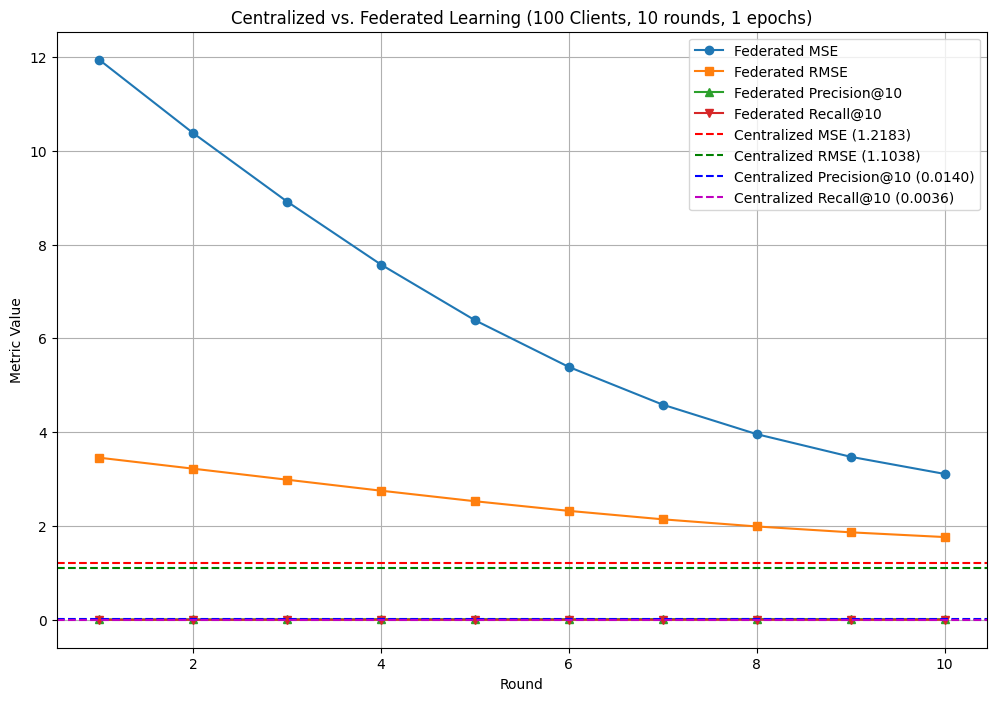

In [ ]:
# Compare Centralized vs. Federated
print(f"\nComparison of Centralized vs. Federated Learning ({num_clients} Users/Clients):")
print(f"{'Method':<12} {'MSE':<8} {'RMSE':<8} {'Precision@10':<12} {'Recall@10':<12}")
print(f"{'Centralized':<12} {central_mse:<8.4f} {central_rmse:<8.4f} {central_prec_10:<12.4f} {central_rec_10:<12.4f}")
print(f"{'Federated':<12} {mse_values[-1]:<8.4f} {rmse_values[-1]:<8.4f} {prec_10_values[-1]:<12.4f} {rec_10_values[-1]:<12.4f}")

# Plot MSE, RMSE, Precision@10, and Recall@10
rounds = range(1, num_rounds + 1)
plt.figure(figsize=(12, 8))
plt.plot(rounds, mse_values, marker='o', label='Federated MSE')
plt.plot(rounds, rmse_values, marker='s', label='Federated RMSE')
plt.plot(rounds, prec_10_values, marker='^', label='Federated Precision@10')
plt.plot(rounds, rec_10_values, marker='v', label='Federated Recall@10')
plt.axhline(y=central_mse, color='r', linestyle='--', label=f'Centralized MSE ({central_mse:.4f})')
plt.axhline(y=central_rmse, color='g', linestyle='--', label=f'Centralized RMSE ({central_rmse:.4f})')
plt.axhline(y=central_prec_10, color='b', linestyle='--', label=f'Centralized Precision@10 ({central_prec_10:.4f})')
plt.axhline(y=central_rec_10, color='m', linestyle='--', label=f'Centralized Recall@10 ({central_rec_10:.4f})')
plt.xlabel('Round')
plt.ylabel('Metric Value')
plt.title(f'Centralized vs. Federated Learning ({num_clients} Clients, {num_rounds} rounds, {num_epochs} epochs)')
plt.legend()
plt.grid(True)
plt.show()